分類（オーバーサンプリング）→回帰

## 必要なライブラリのimport

In [8]:
import os
import warnings
import time
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', 500)

In [17]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [28]:
# データの読み込み
path_train_prepro = '../../../../data/processed/train_processed_20.csv'
train = pd.read_csv(path_train_prepro)
train = reduce_mem_usage(train)
# 分類用
train_cls = train.copy()
train_cls.target = train.target.apply(lambda x: 0 if x<-33 else 1)
target_cls = train_cls['target']
del train_cls['target']

# 回帰用
train_reg = train.query('target > -30').reset_index(drop=True)
target_reg = train_reg['target']
del train_reg['target']

# # 目的変数と説明変数の作成
target = train['target']
del train['target']

Mem. usage decreased to 36.39 Mb (75.1% reduction)


In [29]:
# 特徴量の情報
features = [c for c in train.columns if c not in ['card_id']]
categorical_feats = ['feature_1','feature_2', 'feature_3',
'hist_merchant_category_mode','hist_city_mode','hist_state_mode','hist_category_1_mod','hist_category_2_mod','hist_category_3_mod',
'total_merchant_category_mode','total_city_mode','total_state_mode','total_category_1_mod','total_category_2_mod','total_category_3_mod',
'new_merchant_category_mode','new_city_mode','new_state_mode','new_category_1_mod','new_category_2_mod','new_category_3_mod']

## 回帰

In [19]:
print(len(target_reg[target_reg>0]))

97609


In [30]:
# lightgbmのパラメータ
param = {'num_leaves': 111,
         'min_data_in_leaf': 149,
         'objective':'regression',
         'max_depth': 9,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.7522,
         "bagging_freq": 1,
         "bagging_fraction": 0.7083 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2634,
         "random_state": 133,
         "verbosity": -1}

In [31]:
# データをKFoldで5分割して学習
folds = KFold(n_splits=5, shuffle=True, random_state=26)
oof = np.zeros(len(train_reg))
predictions = np.zeros(len(target_reg))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_reg.values, target_reg.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train_reg.iloc[trn_idx][features],
                           label=target_reg.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(train_reg.iloc[val_idx][features],
                           label=target_reg.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(
                    params = param,
                    train_set=trn_data,
                    num_boost_round=num_round,
                    valid_sets=[val_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=200),
                               lgb.log_evaluation(100)],
                    )

    #clf = lgb.train(param, trn_data)

    oof[val_idx] = clf.predict(train_reg.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # モデルを保存
    os.makedirs('../src/models/lgb_21_reg/', exist_ok=True)
    with open(f'../src/models/lgb_21_reg/model_fold_{fold_}.pkl', 'wb') as f:
        pickle.dump(clf, f)

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target_reg)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 1.64483
[200]	valid_0's rmse: 1.60792
[300]	valid_0's rmse: 1.59052
[400]	valid_0's rmse: 1.58179
[500]	valid_0's rmse: 1.57704
[600]	valid_0's rmse: 1.57423
[700]	valid_0's rmse: 1.57258
[800]	valid_0's rmse: 1.57136
[900]	valid_0's rmse: 1.57063
[1000]	valid_0's rmse: 1.57008
[1100]	valid_0's rmse: 1.56974
[1200]	valid_0's rmse: 1.56953
[1300]	valid_0's rmse: 1.56947
[1400]	valid_0's rmse: 1.56942
[1500]	valid_0's rmse: 1.56937
[1600]	valid_0's rmse: 1.56925
[1700]	valid_0's rmse: 1.56927
[1800]	valid_0's rmse: 1.5693
Early stopping, best iteration is:
[1669]	valid_0's rmse: 1.56923
fold n°1
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 1.64025
[200]	valid_0's rmse: 1.60623
[300]	valid_0's rmse: 1.59094
[400]	valid_0's rmse: 1.58351
[500]	valid_0's rmse: 1.57971
[600]	valid_0's rmse: 1.57746
[700]	valid_0's rmse: 1.57611
[800]	valid_0's rmse: 1.57529
[900

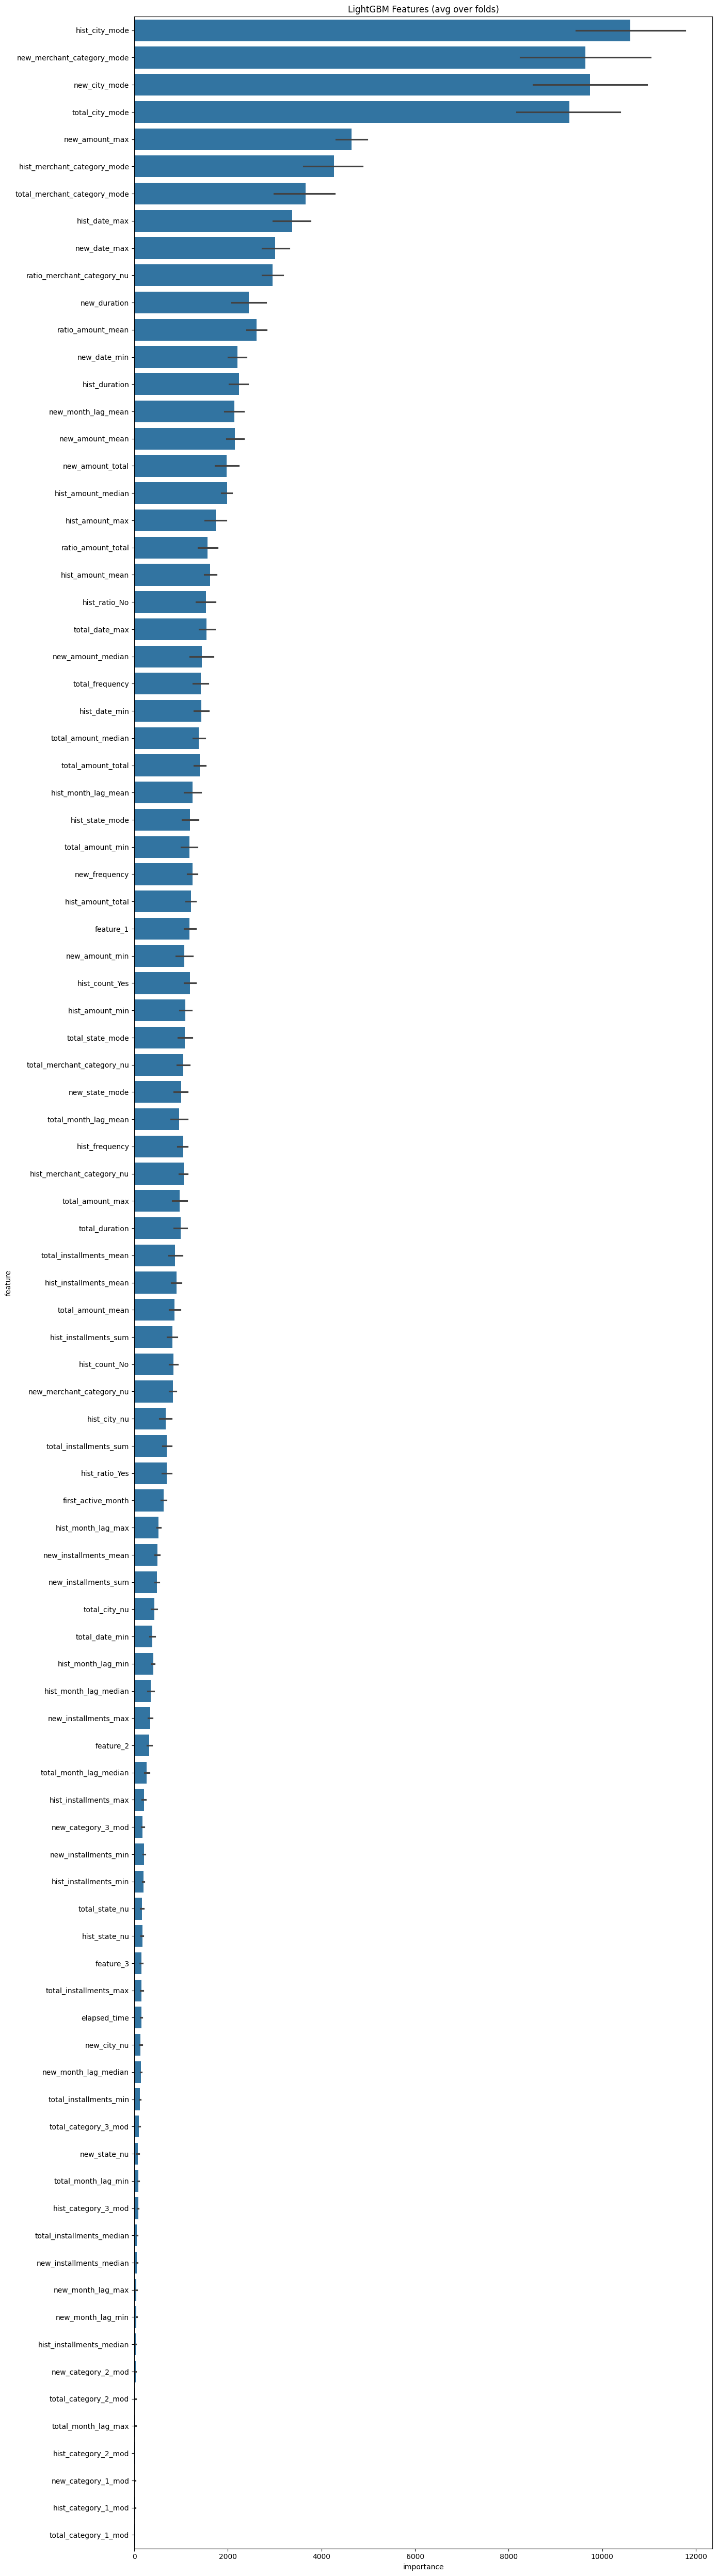

In [32]:
# 特徴量重要度の可視化

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

## 分類

In [33]:
# ハイパーパラメータを指定
param = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'max_depth': 10,
    'learning_rate': 0.01,
    'n_estimators': 100000,
    'importance_type': 'gain',
    'num_leaves': 100,
    'min_data_in_leaf': 100,
    'min_sum_hessian_in_leaf': 10,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'feature_fraction': 0.8,
    'random_seed': 26,
    'verbosity': -1
}

In [34]:
# 不均衡データに対処するためにSMOTEを適用し、トレーニングデータをリサンプリング
smote = SMOTE(random_state=26)
train_cls.fillna(0, inplace=True)
train_cls_smote, target_cls_smote = smote.fit_resample(train_cls[features], target_cls)

Train = train_cls_smote
Target = target_cls_smote

# データをKFoldで5分割して学習
folds = KFold(n_splits=5, shuffle=True, random_state=26)
oof = np.zeros(len(Train))
predictions = np.zeros(len(Target))
start = time.time()
feature_importance_df = pd.DataFrame()


for fold_, (trn_idx, val_idx) in enumerate(folds.split(Train.values, Target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(Train.iloc[trn_idx][features],
                           label=Target.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(Train.iloc[val_idx][features],
                           label=Target.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(
                    params = param,
                    train_set=trn_data,
                    num_boost_round=num_round,
                    valid_sets=[val_data],
                    callbacks=[lgb.early_stopping(stopping_rounds=200),
                               lgb.log_evaluation(100)],
                    )

    oof[val_idx] = clf.predict(Train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # モデルを保存
    os.makedirs('../src/models/lgb_21_cls/', exist_ok=True)
    with open(f'../src/models/lgb_21_cls/model_fold_{fold_}.pkl', 'wb') as f:
        pickle.dump(clf, f)

print("CV AUC score: {:<8.5f}".format(roc_auc_score(Target, oof)))

fold n°0


C:\Users\kakeru.oshikiri.bt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.994287
[200]	valid_0's auc: 0.996383
[300]	valid_0's auc: 0.997532
[400]	valid_0's auc: 0.998153
[500]	valid_0's auc: 0.998488
[600]	valid_0's auc: 0.998654
[700]	valid_0's auc: 0.998754
[800]	valid_0's auc: 0.998821
[900]	valid_0's auc: 0.998877
[1000]	valid_0's auc: 0.99891
[1100]	valid_0's auc: 0.998936
[1200]	valid_0's auc: 0.998954
[1300]	valid_0's auc: 0.998968
[1400]	valid_0's auc: 0.998977
[1500]	valid_0's auc: 0.998981
[1600]	valid_0's auc: 0.998985
[1700]	valid_0's auc: 0.99899
[1800]	valid_0's auc: 0.998991
[1900]	valid_0's auc: 0.99899
[2000]	valid_0's auc: 0.998988
Early stopping, best iteration is:
[1875]	valid_0's auc: 0.998993
fold n°1


C:\Users\kakeru.oshikiri.bt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.994007
[200]	valid_0's auc: 0.99597
[300]	valid_0's auc: 0.99716
[400]	valid_0's auc: 0.997731
[500]	valid_0's auc: 0.998091
[600]	valid_0's auc: 0.998255
[700]	valid_0's auc: 0.998359
[800]	valid_0's auc: 0.998431
[900]	valid_0's auc: 0.998493
[1000]	valid_0's auc: 0.998538
[1100]	valid_0's auc: 0.998576
[1200]	valid_0's auc: 0.998597
[1300]	valid_0's auc: 0.998617
[1400]	valid_0's auc: 0.998633
[1500]	valid_0's auc: 0.998643
[1600]	valid_0's auc: 0.998644
[1700]	valid_0's auc: 0.998648
[1800]	valid_0's auc: 0.998652
[1900]	valid_0's auc: 0.998655
[2000]	valid_0's auc: 0.998653
[2100]	valid_0's auc: 0.998656
Early stopping, best iteration is:
[1936]	valid_0's auc: 0.998657
fold n°2


C:\Users\kakeru.oshikiri.bt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.99394
[200]	valid_0's auc: 0.996173
[300]	valid_0's auc: 0.997373
[400]	valid_0's auc: 0.997983
[500]	valid_0's auc: 0.998267
[600]	valid_0's auc: 0.998404
[700]	valid_0's auc: 0.998488
[800]	valid_0's auc: 0.998562
[900]	valid_0's auc: 0.998609
[1000]	valid_0's auc: 0.998651
[1100]	valid_0's auc: 0.998682
[1200]	valid_0's auc: 0.998705
[1300]	valid_0's auc: 0.99872
[1400]	valid_0's auc: 0.998725
[1500]	valid_0's auc: 0.998734
[1600]	valid_0's auc: 0.998742
[1700]	valid_0's auc: 0.998746
[1800]	valid_0's auc: 0.99875
[1900]	valid_0's auc: 0.998754
[2000]	valid_0's auc: 0.99876
[2100]	valid_0's auc: 0.998764
[2200]	valid_0's auc: 0.998764
[2300]	valid_0's auc: 0.99877
[2400]	valid_0's auc: 0.998767
[2500]	valid_0's auc: 0.998775
[2600]	valid_0's auc: 0.998777
[2700]	valid_0's auc: 0.99878
[2800]	valid_0's auc: 0.998777
Early stopping, best iteration is:
[2699]	valid_0's auc: 0.99878
fold n°3


C:\Users\kakeru.oshikiri.bt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.994202
[200]	valid_0's auc: 0.996174
[300]	valid_0's auc: 0.997347
[400]	valid_0's auc: 0.998
[500]	valid_0's auc: 0.998353
[600]	valid_0's auc: 0.998532
[700]	valid_0's auc: 0.998643
[800]	valid_0's auc: 0.9987
[900]	valid_0's auc: 0.998756
[1000]	valid_0's auc: 0.998797
[1100]	valid_0's auc: 0.998828
[1200]	valid_0's auc: 0.998854
[1300]	valid_0's auc: 0.998862
[1400]	valid_0's auc: 0.998866
[1500]	valid_0's auc: 0.998872
[1600]	valid_0's auc: 0.998875
[1700]	valid_0's auc: 0.99888
[1800]	valid_0's auc: 0.998881
[1900]	valid_0's auc: 0.998881
[2000]	valid_0's auc: 0.998882
Early stopping, best iteration is:
[1876]	valid_0's auc: 0.998883
fold n°4


C:\Users\kakeru.oshikiri.bt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 200 rounds
[100]	valid_0's auc: 0.994175
[200]	valid_0's auc: 0.996175
[300]	valid_0's auc: 0.997386
[400]	valid_0's auc: 0.998033
[500]	valid_0's auc: 0.99838
[600]	valid_0's auc: 0.998549
[700]	valid_0's auc: 0.998658
[800]	valid_0's auc: 0.998738
[900]	valid_0's auc: 0.998787
[1000]	valid_0's auc: 0.998832
[1100]	valid_0's auc: 0.998866
[1200]	valid_0's auc: 0.998882
[1300]	valid_0's auc: 0.998902
[1400]	valid_0's auc: 0.998909
[1500]	valid_0's auc: 0.998923
[1600]	valid_0's auc: 0.998931
[1700]	valid_0's auc: 0.998939
[1800]	valid_0's auc: 0.998944
[1900]	valid_0's auc: 0.998943
[2000]	valid_0's auc: 0.998944
[2100]	valid_0's auc: 0.998944
[2200]	valid_0's auc: 0.998942
Early stopping, best iteration is:
[2095]	valid_0's auc: 0.998945
CV AUC score: 0.99884 


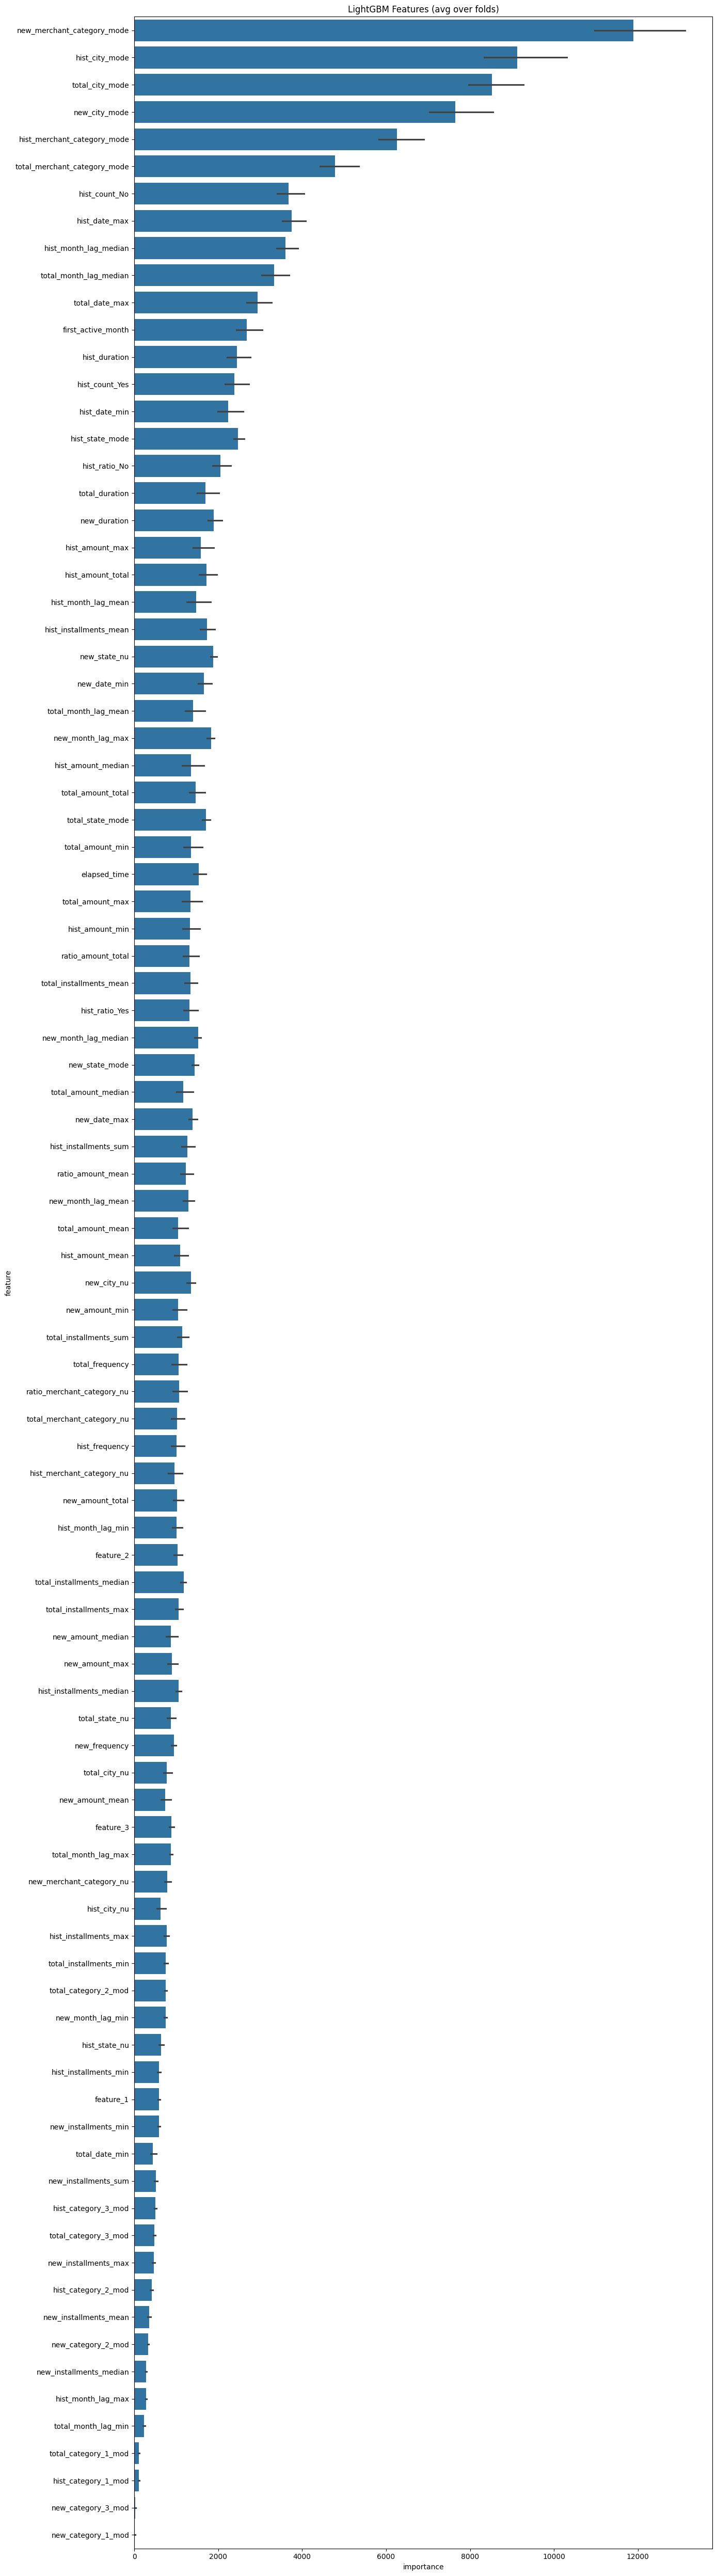

In [35]:
# 特徴量重要度の可視化

cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,50))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
# plt.savefig('lgbm_importances.png')

In [23]:
train_cls.describe()

C:\Users\kakeru.oshikiri.bt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\nanops.py:1487: RuntimeWarning: overflow encountered in cast
  return dtype.type(n)
C:\Users\kakeru.oshikiri.bt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\kakeru.oshikiri.bt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\nanops.py:731: RuntimeWarning: invalid value encountered in scalar divide
  the_mean = the_sum / count if count > 0 else np.nan
C:\Users\kakeru.oshikiri.bt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\nanops

,first_active_month,feature_1,feature_2,feature_3,elapsed_time,hist_frequency,hist_amount_total,hist_amount_mean,hist_amount_max,hist_amount_min,hist_amount_median,hist_merchant_category_nu,hist_merchant_category_mode,hist_city_nu,hist_city_mode,hist_state_nu,hist_state_mode,hist_date_min,hist_date_max,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_median,hist_installments_sum,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_median,hist_category_1_mod,hist_category_2_mod,hist_category_3_mod,hist_ratio_No,hist_ratio_Yes,hist_count_No,hist_count_Yes,hist_duration,new_frequency,new_amount_total,new_amount_mean,new_amount_max,new_amount_min,new_amount_median,new_merchant_category_nu,new_merchant_category_mode,new_city_nu,new_city_mode,new_state_nu,new_state_mode,new_date_min,new_date_max,new_installments_mean,new_installments_max,new_installments_min,new_installments_median,new_installments_sum,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_median,new_category_1_mod,new_category_2_mod,new_category_3_mod,new_duration,total_frequency,total_amount_total,total_amount_mean,total_amount_max,total_amount_min,total_amount_median,total_merchant_category_nu,total_merchant_category_mode,total_city_nu,total_city_mode,total_state_nu,total_state_mode,total_date_min,total_date_max,total_installments_mean,total_installments_max,total_installments_min,total_installments_median,total_installments_sum,total_month_lag_mean,total_month_lag_max,total_month_lag_min,total_month_lag_median,total_category_1_mod,total_category_2_mod,total_category_3_mod,total_duration,ratio_amount_total,ratio_amount_mean,ratio_merchant_category_nu,ratio_installments_mean,ratio_installments_sum
count,201917.000000,201917.000000,201917.000000,201917.000000,201917.000000,201917.00000,2.019170e+05,201917.000000,2.019170e+05,201917.000000,201917.000000,201917.00000,201917.000000,201917.000000,201917.000000,201917.000000,201917.000000,201917.000000,201917.000000,201917.000000,201917.000000,201917.000000,201917.0,201917.000000,201917.000000,201917.000000,201917.000000,201917.0,201917.000000,201917.0,201917.0,201917.000000,201917.000000,201917.0,201917.0,201917.000000,201917.0,201917.000000,201917.000000,201917.000000,201917.000000,201917.000000,201917.0,201917.0,201917.0,201917.0,201917.0,201917.0,201917.0,201917.0,201917.000,201917.0,201917.0,201917.0,201917.0,201917.000000,201917.0,201917.0,201917.0,201917.0,201917.0,201917.0,201917.0,201917.000000,2.019170e+05,201917.000000,2.019170e+05,201917.000000,201917.000000,201917.000000,201917.000000,201917.000000,201917.000000,201917.000000,201917.000000,201917.000000,201917.000000,201917.000000,201917.000000,201917.000000,201917.0,201917.000000,201917.000000,201917.000000,201917.000000,201917.0,201917.000000,201917.0,201917.0,201917.000000,201917.000000,201917.000000,201917.000000,2.019170e+05,2.019170e+05
mean,1902.021019,3.105311,1.745410,0.565569,381.978981,89.29416,1.442567e+01,2.459431,6.667165e+01,NaN,NaN,18.27803,521.900915,4.901628,131.988832,2.730860,10.639248,132.744648,376.959865,NaN,4.253163,0.055993,NaN,57.854049,NaN,-0.166058,-7.877777,NaN,0.063293,NaN,NaN,0.000000,NaN,NaN,NaN,243.678269,NaN,NaN,NaN,-0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,95.334687,1.109020e+01,1.506766,6.677648e+01,NaN,NaN,20.652709,518.144049,5.430221,133.026184,2.927322,10.729092,132.744648,426.997900,NaN,4.401734,-0.036609,NaN,61.978100,NaN,1.591015,-7.877777,NaN,0.057326,NaN,NaN,293.681904,0.000000,NaN,0.000000,NaN,NaN
std,293.710176,1.186160,0.751362,0.495683,293.710176,104.60598,1.344916e+04,1115.169189,1.344855e+04,0.000000,0.000000,11.47046,240.437453,3.496264,107.401708,1.516658,6.507306,119.118043,74.769525,0.000000,22.941158,0.723225,0.0,100.708774,0.000000,0.636972,3.843313,0.0,0.243490,0.0,0.0,0.000000,0.000000,NaN,NaN,118.291731,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,0.0,NaN,0.0

In [36]:
train_cls_smote

,first_active_month,feature_1,feature_2,feature_3,elapsed_time,hist_frequency,hist_amount_total,hist_amount_mean,hist_amount_max,hist_amount_min,hist_amount_median,hist_merchant_category_nu,hist_merchant_category_mode,hist_city_nu,hist_city_mode,hist_state_nu,hist_state_mode,hist_date_min,hist_date_max,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_median,hist_installments_sum,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_median,hist_category_1_mod,hist_category_2_mod,hist_category_3_mod,hist_ratio_No,hist_ratio_Yes,hist_count_No,hist_count_Yes,hist_duration,new_frequency,new_amount_total,new_amount_mean,new_amount_max,new_amount_min,new_amount_median,new_merchant_category_nu,new_merchant_category_mode,new_city_nu,new_city_mode,new_state_nu,new_state_mode,new_date_min,new_date_max,new_installments_mean,new_installments_max,new_installments_min,new_installments_median,new_installments_sum,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_median,new_category_1_mod,new_category_2_mod,new_category_3_mod,new_duration,total_frequency,total_amount_total,total_amount_mean,total_amount_max,total_amount_min,total_amount_median,total_merchant_category_nu,total_merchant_category_mode,total_city_nu,total_city_mode,total_state_nu,total_state_mode,total_date_min,total_date_max,total_installments_mean,total_installments_max,total_installments_min,total_installments_median,total_installments_sum,total_month_lag_mean,total_month_lag_max,total_month_lag_min,total_month_lag_median,total_category_1_mod,total_category_2_mod,total_category_3_mod,total_duration,ratio_amount_total,ratio_amount_mean,ratio_merchant_category_nu
0,2039,5,2,1,245,260,-165.968735,-0.638341,2.258394,-0.739258,-0.698242,41,560,7,69,3,9,177,420,0.015381,1,0,0.000000,4,-3.912109,0,-8,-4.000000,0,1.000000,1.000000,0.049988,0.950195,13.000000,247.000000,242,23.000000,-13.242188,-0.575684,-0.296143,-0.724609,-0.581055,14.000000,278.00000,3.000000,69.000000,1.000000,9.000000,369.000000,424.0000,0.000000,0.000000,0.000000,0.000000,0.000000,1.478516,2.000000,1.000000,1.000000,0.0,1.000000,1.000000,54.000000,283,-179.212631,-0.633260,2.258394,-0.739258,-0.695801,46,560,9,69,3,9,177,483,0.014137,1,0,0.000000,4,-3.472656,2,-8,-3.000000,0,1.000000,1.000000,305,0.079773,0.901855,0.341553
1,1888,4,1,0,396,350,-210.006332,-0.600018,4.630300,-0.742188,-0.708496,57,307,9,69,3,9,5,395,1.551758,10,-1,1.000000,543,-5.031250,0,-12,-5.000000,0,1.000000,2.000000,0.031433,0.968750,11.000000,339.000000,390,6.000000,-4.355469,-0.726074,-0.701660,-0.739258,-0.732422,5.000000,307.00000,1.000000,69.000000,1.000000,9.000000,337.000000,394.0000,1.000000,1.000000,1.000000,1.000000,6.000000,1.500000,2.000000,1.000000,1.500000,0.0,1.000000,2.000000,56.000000,356,-214.361801,-0.602140,4.630300,-0.742188,-0.708984,58,307,9,69,3,9,5,453,1.541992,10,-1,1.000000,549,-4.921875,2,-12,-5.000000,0,1.000000,2.000000,447,0.020737,1.209961,0.087708
2,1735,2,2,0,549,43,-29.167391,-0.678311,-0.145847,-0.729980,-0.698730,8,705,5,143,2,5,10,422,0.000000,0,0,0.000000,0,-8.601562,0,-13,-10.000000,0,5.000000,1.000000,0.046509,0.953613,2.000000,41.000000,412,1.000000,-0.700195,-0.700195,-0.700195,-0.700195,-0.700195,1.000000,528.00000,1.000000,143.000000,1.000000,5.000000,423.000000,423.0000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,0.0,5.000000,1.000000,0.000000,44,-29.867586,-0.678809,-0.145847,-0.729980,-0.699707,9,705,5,143,2,5,10,482,0.000000,0,0,0.000000,0,-8.367188,2,-13,-10.000000,0,5.000000,1.000000,472,0.024002,1.032227,0.125000
3,2131,4,3,0,153,77,-49.491364,-0.642745,1.445596,-0.740723,-0.708008,25,278,7,17,5,22,268,423,1.090820,3,-1,1.000000,84,-2.832031,0,-5,-4.000000,0,4.000000,2.000000,0.000000,1.000000,0.000000,77.000000,154,7.000000,-4.656250,-0.665039,-0.566895,-0.734375,-0.691406,6.000000,80.00000,2.000000,17.000000,2.000000,22.000000,371.000000,413.0000,0.714355,1.000000,-1.000000,1.0000

In [ ]:
train_cls_smote

,first_active_month,feature_1,feature_2,feature_3,elapsed_time,hist_frequency,hist_amount_total,hist_amount_mean,hist_amount_max,hist_amount_min,hist_amount_median,hist_merchant_category_nu,hist_merchant_category_mode,hist_city_nu,hist_city_mode,hist_state_nu,hist_state_mode,hist_date_min,hist_date_max,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_median,hist_installments_sum,hist_month_lag_mean,hist_month_lag_max,hist_month_lag_min,hist_month_lag_median,hist_category_1_mod,hist_category_2_mod,hist_category_3_mod,hist_ratio_No,hist_ratio_Yes,hist_count_No,hist_count_Yes,hist_duration,new_frequency,new_amount_total,new_amount_mean,new_amount_max,new_amount_min,new_amount_median,new_merchant_category_nu,new_merchant_category_mode,new_city_nu,new_city_mode,new_state_nu,new_state_mode,new_date_min,new_date_max,new_installments_mean,new_installments_max,new_installments_min,new_installments_median,new_installments_sum,new_month_lag_mean,new_month_lag_max,new_month_lag_min,new_month_lag_median,new_category_1_mod,new_category_2_mod,new_category_3_mod,new_duration,total_frequency,total_amount_total,total_amount_mean,total_amount_max,total_amount_min,total_amount_median,total_merchant_category_nu,total_merchant_category_mode,total_city_nu,total_city_mode,total_state_nu,total_state_mode,total_date_min,total_date_max,total_installments_mean,total_installments_max,total_installments_min,total_installments_median,total_installments_sum,total_month_lag_mean,total_month_lag_max,total_month_lag_min,total_month_lag_median,total_category_1_mod,total_category_2_mod,total_category_3_mod,total_duration,ratio_amount_total,ratio_amount_mean,ratio_merchant_category_nu
0,2039,5,2,1,245,260,-165.968735,-0.638341,2.258394,-0.739258,-0.698242,41,560,7,69,3,9,177,420,0.015381,1,0,0.000000,4,-3.912109,0,-8,-4.000000,0,1.000000,1.000000,0.049988,0.950195,13.000000,247.000000,242,23.000000,-13.242188,-0.575684,-0.296143,-0.724609,-0.581055,14.000000,278.00000,3.000000,69.000000,1.000000,9.000000,369.000000,424.0000,0.000000,0.000000,0.000000,0.000000,0.000000,1.478516,2.000000,1.000000,1.000000,0.0,1.000000,1.000000,54.000000,283,-179.212631,-0.633260,2.258394,-0.739258,-0.695801,46,560,9,69,3,9,177,483,0.014137,1,0,0.000000,4,-3.472656,2,-8,-3.000000,0,1.000000,1.000000,305,0.079773,0.901855,0.341553
1,1888,4,1,0,396,350,-210.006332,-0.600018,4.630300,-0.742188,-0.708496,57,307,9,69,3,9,5,395,1.551758,10,-1,1.000000,543,-5.031250,0,-12,-5.000000,0,1.000000,2.000000,0.031433,0.968750,11.000000,339.000000,390,6.000000,-4.355469,-0.726074,-0.701660,-0.739258,-0.732422,5.000000,307.00000,1.000000,69.000000,1.000000,9.000000,337.000000,394.0000,1.000000,1.000000,1.000000,1.000000,6.000000,1.500000,2.000000,1.000000,1.500000,0.0,1.000000,2.000000,56.000000,356,-214.361801,-0.602140,4.630300,-0.742188,-0.708984,58,307,9,69,3,9,5,453,1.541992,10,-1,1.000000,549,-4.921875,2,-12,-5.000000,0,1.000000,2.000000,447,0.020737,1.209961,0.087708
2,1735,2,2,0,549,43,-29.167391,-0.678311,-0.145847,-0.729980,-0.698730,8,705,5,143,2,5,10,422,0.000000,0,0,0.000000,0,-8.601562,0,-13,-10.000000,0,5.000000,1.000000,0.046509,0.953613,2.000000,41.000000,412,1.000000,-0.700195,-0.700195,-0.700195,-0.700195,-0.700195,1.000000,528.00000,1.000000,143.000000,1.000000,5.000000,423.000000,423.0000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,0.0,5.000000,1.000000,0.000000,44,-29.867586,-0.678809,-0.145847,-0.729980,-0.699707,9,705,5,143,2,5,10,482,0.000000,0,0,0.000000,0,-8.367188,2,-13,-10.000000,0,5.000000,1.000000,472,0.024002,1.032227,0.125000
3,2131,4,3,0,153,77,-49.491364,-0.642745,1.445596,-0.740723,-0.708008,25,278,7,17,5,22,268,423,1.090820,3,-1,1.000000,84,-2.832031,0,-5,-4.000000,0,4.000000,2.000000,0.000000,1.000000,0.000000,77.000000,154,7.000000,-4.656250,-0.665039,-0.566895,-0.734375,-0.691406,6.000000,80.00000,2.000000,17.000000,2.000000,22.000000,371.000000,413.0000,0.714355,1.000000,-1.000000,1.0000